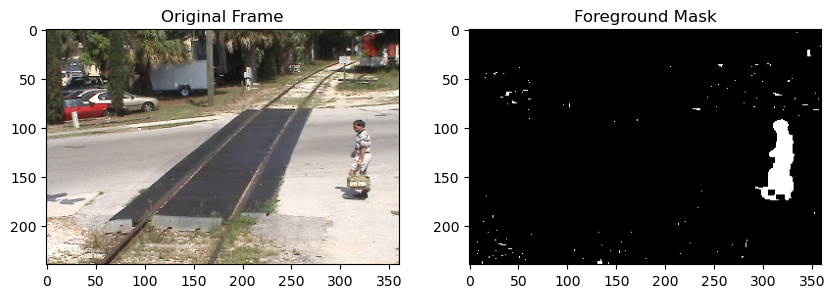

In [1]:
import cv2
import numpy as np
import os

# Function to read frames from a directory
def read_frames(directory):
    frames = []
    for filename in sorted(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        frames.append(img)
    return frames

# Function to compute frame differences and generate foreground masks
def frame_difference_method(frames, masks):
    # Initialize an empty list to store foreground masks
    foreground_masks = []
    
    # Iterate through frames and masks
    for i in range(len(frames) - 1):
        # Compute absolute difference between consecutive frames
        frame_diff = cv2.absdiff(frames[i], frames[i + 1])
        
        # Convert to grayscale
        frame_diff_gray = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
        
        # Apply thresholding to obtain binary mask
        _, mask = cv2.threshold(frame_diff_gray, 30, 255, cv2.THRESH_BINARY)
        
        # Apply morphology to refine the mask
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # Append the mask to the list
        foreground_masks.append(mask)
    
    return foreground_masks

# Paths to RawImages and Masks folders
raw_images_dir = "RawImages"
masks_dir = "Masks"

# Read frames and masks
frames = read_frames(raw_images_dir)
masks = read_frames(masks_dir)[:100]  # Use masks for the first 100 frames

# Apply frame differencing method
foreground_masks = frame_difference_method(frames[:100], masks)

# Display some results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(frames[50])
plt.title('Original Frame')

plt.subplot(1, 2, 2)
plt.imshow(foreground_masks[50], cmap='gray')
plt.title('Foreground Mask')

plt.show()

In [142]:
import av
from IPython.display import Video

# Output video file path
output_video_path = 'frame_differences.mp4'

# Function to write frames to video
def write_video(frames, output_video_path, conv = None):
    # Define output video stream
    output_container = av.open(output_video_path, mode='w')
    output_stream = output_container.add_stream('h264', rate=30)
    output_stream.width = frames[0].shape[1]
    output_stream.height = frames[0].shape[0]
    output_stream.pix_fmt = 'yuv420p'

    # Iterate through frames and write to video
    for frame in frames:
        if conv is not None:
            frame = conv(frame)  # Convert frame 
        frame = av.VideoFrame.from_ndarray(frame, format='rgb24')
        packet = output_stream.encode(frame)
        output_container.mux(packet)

    # Flush the encoder
    packet = output_stream.encode(None)
    output_container.mux(packet)

    # Close the video file
    output_container.close()

gray2rgb = lambda f: cv2.cvtColor(f, cv2.COLOR_GRAY2RGB)
# Write frame differences to video
write_video(foreground_masks, output_video_path, conv=gray2rgb)
Video(output_video_path, html_attributes="controls autoplay loop")

In [143]:
from skimage.morphology import remove_small_objects, binary_opening, \
    binary_closing, binary_erosion, binary_dilation

def refine_masks(foreground_masks):
    refined_masks = []
    
    for mask in foreground_masks:
        mask = mask > 0
        mask = binary_erosion(mask)
        mask = binary_dilation(mask)
        mask = remove_small_objects(mask > 0, min_size=64, connectivity=2)
        mask = mask.astype('uint8') * 255
        refined_masks.append(mask)
    
    return refined_masks

output_video_path = 'refined_frames.mp4' 
refined_foreground_masks = refine_masks(foreground_masks)
write_video(refined_foreground_masks, output_video_path, gray2rgb)
Video(output_video_path)

In [241]:
# Function to compute mean of frames
def compute_mean(frames):
    return np.mean(frames, axis=0)

# Function to apply mean filtering method
def mean_filtering_method(frames, window_size=3):
    # Initialize an empty list to store foreground masks
    foreground_masks = []
    frames = np.array([cv2.cvtColor(f, cv2.COLOR_BGR2GRAY).astype('uint8')
                       for f in frames])
    print(frames[0].mean(), frames[0].dtype)
    # Compute mean of first `window_size` frames
    background_model = compute_mean(frames[:window_size]).astype('float32')
    
    # Iterate through frames
    for frame in frames:
        # Compute absolute difference between frame and background model
        frame_diff = abs(frame - background_model)
        mask = (frame_diff >= 32)
        mask = binary_opening(mask)
        foreground_masks.append(mask.astype('uint8') * 255)
        
        # Update background model by adding the current frame and removing the oldest frame
        background_model = background_model * .95 + frame * .05
    return foreground_masks

# Apply mean filtering method
foreground_masks_mean = mean_filtering_method(frames,)

# Write foreground masks to video
output_video_path_mean = 'foreground_masks_mean.mp4'
! rm foreground_masks_mean.mp4
write_video(foreground_masks_mean, output_video_path_mean, gray2rgb)

# Display the video
Video(output_video_path_mean, embed=True)

137.01518518518517 uint8


In [242]:
# Function to compute mean of frames
def compute_median(frames):
    return np.median(frames, axis=0)

# Function to apply mean filtering method
def mean_filtering_method(frames, window_size=3):
    # Initialize an empty list to store foreground masks
    foreground_masks = []
    frames = np.array([cv2.cvtColor(f, cv2.COLOR_BGR2GRAY).astype('uint8')
                       for f in frames])
    print(frames[0].mean(), frames[0].dtype)
    # Compute mean of first `window_size` frames
    background_model = compute_median(frames[:window_size]).astype('float32')
    
    # Iterate through frames
    for frame in frames:
        # Compute absolute difference between frame and background model
        frame_diff = abs(frame - background_model)
        mask = (frame_diff >= 32)
        # mask = binary_opening(mask)
        foreground_masks.append(mask.astype('uint8') * 255)
        
        # Update background model by adding the current frame and removing the oldest frame
        background_model = background_model * .95 + frame *.05
        # background_model = background_model - (frames[0] - frames[window_size]) / window_size
        # background_model = np.clip(background_model, 0, 255)
    return foreground_masks

# Apply mean filtering method
foreground_masks_mean = mean_filtering_method(frames,)

# Write foreground masks to video
output_video_path_mean = 'foreground_masks_mean.mp4'
!rm foreground_masks_mean.mp4
write_video(foreground_masks_mean, output_video_path_mean, gray2rgb)

# Display the video
Video(output_video_path_mean, embed=True)

137.01518518518517 uint8
